In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interactive, widgets

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,10)

# Error Analysis
In this notebook I want to analyze and visualize the errors associated with retrievals of components using HYDROPT for case I waters. The 5 components that are retrieved are CDOM, NAP, pico, nano and micro phytoplankton. For case I waters we assume covaration between chlorophyll-a concentration and CDOM absorption (for more information see my word document that I send you a while ago - *Retrieval of phytoplankton size classes using a radiative transfer approach*.

As discussed before, inversion of certain spectra result in retrievals with high errors. So here I want to make it easy to visualize these errors and see how the errors relate between retrievals of different components.

The error metric that I use is the absolute $log_{10}$ error:

$$
{\delta} = |log_{10}(observed) - log_{10}(predicted)| = |log_{10}(\frac{observed}{predicted})|
$$


Run the 3 cells below to load the data...

In [4]:
# load inversion dataset
c1_psc_inversion = pd.read_csv('./data/c1_psc_noise_inversion_results_all.csv', index_col=[0,1])

In [5]:
# load rrs inversion dataset
c1_rrs_inversion = pd.read_csv('./data/c1_rrs_noise_inversion_results.csv', index_col=1)
c1_rrs_inversion = c1_rrs_inversion.drop(c1_rrs_inversion.columns[0], axis=1)
#pivot
c1_rrs_inversion_pivot = c1_rrs_inversion.reset_index().pivot(index='wavelength', columns='id', values='rrs_obs');

In [6]:
# calculate log10 errors
err_abs = pd.DataFrame({
    'cdom': (np.log10(c1_psc_inversion.loc['cdom'].observed/c1_psc_inversion.loc['cdom'].predicted)),
    'nap':(np.log10(c1_psc_inversion.loc['nap'].observed/c1_psc_inversion.loc['nap'].predicted)),
    'pico': (np.log10(c1_psc_inversion.loc['pico'].observed/c1_psc_inversion.loc['pico'].predicted)),
    'nano': (np.log10(c1_psc_inversion.loc['nano'].observed/c1_psc_inversion.loc['nano'].predicted)),
    'micro': (np.log10(c1_psc_inversion.loc['micro'].observed/c1_psc_inversion.loc['micro'].predicted))
})

Run the cell below to start an interactive plot to visualize the retrieval errors. Once you run the cell you will see a dropdown menu (named ```component```) that you can use to select one of the 5 components for which you want to visualize the errors. The slider (named $\delta >$) specifies the datapoints with $|log_{10}|$ errors greater than $\delta$ that will be highlighted in red once you hit ```Run Interact```.

A couple of points that stand out to me.
For NAP (set component to NAP and $\delta >$ slider to 6.3 for instance):
  * high error datapoints for NAP coincide with observed pico concentrations of $10^{-1}\ mg\ m^{-3}$ 
  * high error datapoints for NAP **do not** coincide with high error datapoints for the other 3 components
  * the observed spectra for high error NAP datapoints are tightly clustered together and are predominantely spectra of low reflectance values

For pico, nano and micro's:
* high error datapoints for pico's/micro's **do not** coincide with with high error datapoints for the other components (set component to pico and micro and $\delta >$ slider to 6.4)
* for nano's, most high error datapoints do not coincide with other high error datapoints - there is some overlap with high error datapoints for micro's (set component to nano and $\delta >$ slider to 6.4)
* the spectra where retrievals fail for pico's and nano's have a similair spectral shape (for pico's but $\delta >$ at 7.9 and for nano's put $\delta >$ at 8.5). Spectra for micro's have more reflection in the blue compared to pico's and nano's (for micros put $\delta >$ at 8 )

In [18]:
#specify OLCI wavebands
olci_wbands = np.array([400,412.5,442.5,490,510,560,620,665,673.75,681.25,708.75])
# create color mapping according to cdom+nap concentration
col = np.log10(c1_psc_inversion.loc['chl_a442'].observed)
# plot variables
pnames = ['tot_a442','tot_b510','cdom','nap','chl','nano','pico','micro']
# selection widgets
component_widget = widgets.Dropdown(options=['pico','nano','micro','nap','cdom'], value='pico', description='component')
error_widget =  widgets.FloatSlider(min=1, max=7.9, step=.1, value=7, description='$\delta >$')

def update_error_widget(*args):
    error_widget.max = np.abs(err_abs[component_widget.value]).max()
 # observe component selection widget       
component_widget.observe(update_error_widget, 'value')

def plot_validation(psc, err):
    fig = plt.figure(figsize=(16,18))
    gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,3])
    axs = [fig.add_subplot(gs[i]) for i in range(8)]
    axs.append(fig.add_subplot(gs[3,:]))
    axs = iter(axs)
    # fetch indices with errors > err
    err_id = np.where(np.abs(err_abs[psc])>=err)[0]
    for (name, data) in c1_psc_inversion.groupby(level=0, sort=False):
        if name not in pnames:
            continue
        ax = next(axs)
        # mask nans
        X,Y = data.observed.values, data.predicted.values
        mask = ~np.any([np.isnan(Y), [i==0 for i in Y]], axis=0)
        # determine min and max of axes
        ax_min, ax_max = [np.min(X[mask])*.2, np.max(Y[mask])*2.5]
        ay_min, ay_max = [np.min(Y[mask])*.2, np.max(Y[mask])*2.5]
        # log-transform x and y
        X_log, Y_log = np.log10(X[mask]).reshape(-1,1), np.log10(Y[mask]).reshape(-1,1)
        # plot scatter
        ax.scatter(data.observed, data.predicted, color='blue', alpha=.5)
        ax.scatter(data.observed[err_id], data.predicted[err_id], color='red', alpha=.5)
        ax.plot(np.linspace(ax_min, ax_max),
                np.linspace(ax_min, ax_max), 'k', linewidth=.7)
        # regression line
        x_log_range = np.logspace(np.log10(ax_min), np.log10(ax_max))
        # set axis labels and scale
        ax.set_xlabel('observed ({})'.format(data.units[0]))
        ax.set_ylabel('predicted ({})'.format(data.units[0]))
        ax.set_xscale('log')
        ax.set_yscale('log')
        # set axis limits
        ax.set_title(name)
        ax.set_xlim([ax_min, ax_max])
        ax.set_ylim([ay_min, ay_max])
    
    ax = next(axs)
    
    ax.plot(olci_wbands, c1_rrs_inversion_pivot, color='blue', alpha=.2)
    if err_id.size != 0:
        ax.plot(olci_wbands, c1_rrs_inversion_pivot[err_id], color='red', alpha=.5)
    ax.set_xlabel('wavelength (nm)')
    ax.set_ylabel('$R_{rs} (sr^{-1})$')
    
    fig.subplots_adjust(right=0.8)
    plt.tight_layout()
    #return fig

    
widgets.interact_manual(plot_validation, psc=component_widget, err=error_widget);

interactive(children=(Dropdown(description='component', options=('pico', 'nano', 'micro', 'nap', 'cdom'), valu…

## Spectral comparison

Lets compare observed and predicted spectra by again selecting a component and specifying $\delta$:

In [33]:
# get indices for retrievals where nano log errors are higher than 6
spectrum_widget = widgets.IntSlider(min=0, value=0)

def update_spectrum_widget(*args):
    spectrum_widget.max = (np.abs(err_abs[component_widget.value])>=error_widget.value).sum()-1

component_widget.observe(update_spectrum_widget, 'value')
error_widget.observe(update_spectrum_widget, 'value')

def plot_compare_spectra(spectrum, err, comp):
    err_id = np.where(np.abs(err_abs[comp])>=err)[0]
    idx = err_id[spectrum]
    plt.plot(c1_rrs_inversion.loc[idx].wavelength, c1_rrs_inversion.loc[idx].rrs_obs, label='observed')
    plt.plot(c1_rrs_inversion.loc[idx].wavelength, c1_rrs_inversion.loc[idx].rrs_pred, label='predicted')
    plt.ylim(0,.025)
    plt.legend()
    
def iplot_compare_spectra():
    iplot = interactive(plot_compare_spectra, spectrum=spectrum_widget, comp=component_widget, err=error_widget)
    output = iplot.children[-1]
    output.layout.height = '800px'
    return iplot

iplot_compare_spectra()

interactive(children=(IntSlider(value=0, description='spectrum'), FloatSlider(value=7.4, description='$\\delta…

## Correlations plots and matrix
Here I visualize the errors in another way using pairplots and a correlation matrix. The x and y-axis indicate the absolute $log_{10}$ as defined above ($\delta$). Again here we see, for almost all components, that high errors of one component **do not** coincide with high errors of the other components. Quiet to the contrary - most high error datapoints of one component coincide with relatively low error datapoints of the other components. 

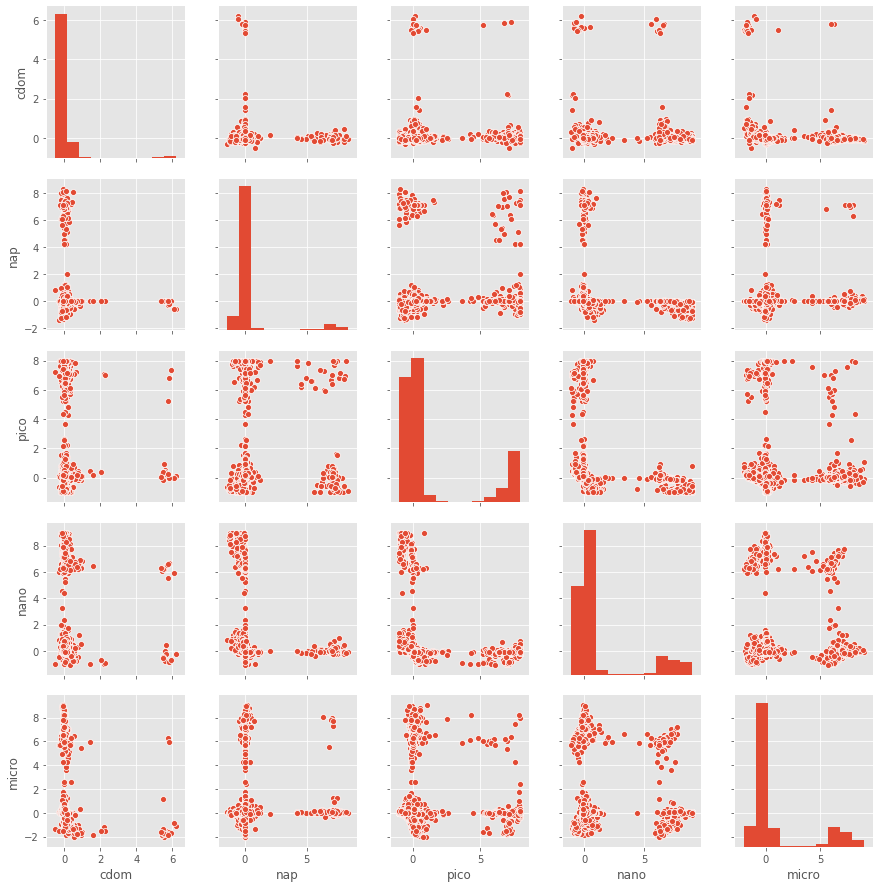

In [20]:
sns.pairplot(err_abs);

We can also quanitfy the degree of correlation using a correlation matrix:

In [22]:
err_abs.corr().style.background_gradient()

From the correlation matrix I would conclude the same as above. Most terms in the matrix are rather small (no significant correlation), and when there is a correlation it is mostly negative (i.e. high errors of one component correlate with low errors of the other component)